# Preprocesamiento

Dentro de este documento se realizará parte del preprocesamiento que se realizará al corpus previamente definido de acuerdo con las observaciones sugeridas. Este procesamiento incluye limpieza de datos, algunas transformaciones y gráficas pertinentes del proceso que se llevó a cabo.

Este preprocesamiento incluye:
1. Tokenizacion
2. Stemming
3. Preprocesamiento de stopwords
    1. Stopwords generales.
    2. Números.
    3. Palabras en inglés y otros símbolos.
4. Calculo tf idf
5. Gráficas

In [1]:
#Importar elementos necesarios de las librerías
import os, shutil, re, pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from nltk.corpus import PlaintextCorpusReader, stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.snowball import SpanishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [2]:
#Ruta del corpus
ruta = "D:/Documents/Documentos Universidad/Noveno/Proyecto de grado/textos"

#ruta de los resumenes de referencia
ruta_referencias = "D:/Documents/Documentos Universidad/Noveno/Proyecto de grado/referencias"

In [3]:
#Funciones auxiliares

def read_files(path,stemmer=None):
    #Tokeniza un corpus usando los documentos de una ruta y devuelve una lista con el tamaño del corpus
    corpus, size = [], []
    files = os.listdir(path)
    if stemmer == None:
        #Proceso de tokenización sin stemming
        for file in files:
            texto = PlaintextCorpusReader(ruta, file)
            size.append(len(texto.words()))
            texto = texto.raw()
            corpus.append(texto)
    else:
        #Proceso de tokenización con stemming
        for file in files:
            texto = PlaintextCorpusReader(ruta, file)
            tokens = texto.words()
            size.append(len(texto.words()))
            tokens = [stemmer.stem(token) for token in tokens]
            texto = ' '.join(tokens)
            corpus.append(texto)
    return corpus, size

def tokenize_sentence(path, file_name):
    #Retorna un documento tokenizado por frases
    doc = []
    text = PlaintextCorpusReader(path, file_name)
    paragraphs = text.paras()
    for paragraph in paragraphs:
        for sentence in paragraph:
            low, i = 0,0
            while i < len(sentence):
                token = sentence[i].split('.')
                if len(token)-1:
                    doc.append(sentence[low:i])
                    low=i+1
                    i+=2
                else:
                    i+=1
            if low!=i-1:
                doc.append(sentence[low:i])
    return doc

def sentences_path(path,file_list):
    #Retorna una lista con el número de frases de cada documento especificado en la lista
    sentences_corpus = []
    for filename in file_list:
        text = tokenize_sentence(path, filename)
        sentences_text = len(text)
        sentences_corpus.append(sentences_text)
    return sentences_corpus

def tf_idf_to_dataframe(array_tf_idf,path):
    #Crea un dataframe a partir de un array que contenga el tf-idf de un corpus
    files = os.listdir(path)
    for i, doc in enumerate(array_tf_idf):
        title = files[i].replace(".txt","")
        tf_idf_single_document = list(zip(tf_idf.get_feature_names(), doc, [i for _ in range(len(doc))], [title for _ in range(len(doc))]))
        if i == 0:
            df = pd.DataFrame(tf_idf_single_document, columns=['token', 'tf_idf','id_documento','nombre_documento'])
        else:
            df2 = pd.DataFrame(tf_idf_single_document, columns=['token', 'tf_idf','id_documento','nombre_documento'])
            df = df.append(df2)
    return df

def plot_bar(title,x,y,x_name,y_name,scale=None):
    #Función auxiliar para realizar graficos de barras
    plt.bar(x, y, align='center', alpha=0.5)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    if scale != None: plt.yscale(scale)
    plt.title(title)
    plt.grid()
    plt.show()

def plot_tf_idf(array_tf_idf,path,size):
    #Grafica el tf-idf de cada documento de una ruta e imprime el tamaño de cada documento
    files = os.listdir(path)
    for i, doc in enumerate(array_tf_idf):
        document_title = files[i].replace(".txt","")
        print("Cantidad de tokens del documento de {}: {}".format(document_title,size[i]))
        x_axis = [i for i in range(len(doc))]
        plot_bar(document_title,x_axis,doc,'Llaves del token','Tf-idf','log')
        
def plot_general_tf_idf(array_tf_idf,path,tokens):
    #Grafica el tf-idf máximo y promedio de cada token en el corpus
    files = os.listdir(path)
    max_tf_idf, mean_tf_idf = [0 for _ in range(tokens)], [0 for _ in range(tokens)]
    for i, doc in enumerate(array_tf_idf):
        tf_idf_single_document = list(zip(tf_idf.get_feature_names(), doc, [i for _ in range(len(doc))]))
        document_title = files[i].replace(".txt","")
        max_tf_idf = [max(max_tf_idf[j],doc[j]) for j in range(tokens)]
        mean_tf_idf = [mean_tf_idf[j] + doc[j] for j in range(tokens)]
    mean_tf_idf = [mean_tf_idf[j]/(i+1) for j in range(tokens)]
    x_axis = [i for i in range(tokens)]
    plot_bar('Tf-idf máximo',x_axis,max_tf_idf,'Llave del token','Tf-idf','log')
    plot_bar('Tf-idf promedio',x_axis,mean_tf_idf,'Llave del token','Tf-idf','log')

def show_top_tokens(df,path,n):
    #Muestra los tokens con mayor tf-idf de cada documento
    files = os.listdir(path)
    for text in files:
        title = text.replace(".txt","")
        print(df[df.nombre_documento == title].head(n),'\n\n')

def get_regex_corpus_list(path,regex):
    #obtiene una lista de los tokens de un corpus que coincidan con una expresión regular
    corpus, regex_list = [], []
    files = os.listdir(path)
    for file in files:
        texto = PlaintextCorpusReader(ruta, file)
        tokens = texto.words()
        regex_list += [token for token in tokens if regex.match(token)]
    regex_list = list(set(regex_list))
    return regex_list

def stemming_sentece(doc, stopwords, stemmer):
    #Aplica el proceso de stemming a un documento tokenizado por frases, sin considerar las stopwords.
    #Adicionalmente, retorna el documento original sin las filas vacías por el preprocesamiento 
    doc_preprocesed, doc_reduced = [], []
    for original_sentence in doc:
        preprocessed_sentence = []
        for token in original_sentence:
            if stemmer.stem(token) not in stopwords:
                preprocessed_sentence.append(stemmer.stem(token))
        if len(preprocessed_sentence) and preprocessed_sentence not in doc_preprocesed:
            doc_preprocesed.append(preprocessed_sentence)
            doc_reduced.append(original_sentence)
    return doc_preprocesed, doc_reduced

# Preprocesamiento general
## Fase 1. y Fase 2. Tokenización y Stemming

In [4]:
stemmer = SpanishStemmer()

#Tokenización y stemming
corpus, tamaño = read_files(ruta,stemmer)

In [5]:
#Tokenización y stemming
corpus_sin_stemm, tamaño = read_files(ruta)

#Cantidad de tokens 
tf_idf = TfidfVectorizer()
tokens = tf_idf.fit_transform(corpus_sin_stemm)
tokens.shape

(56, 11370)

In [6]:
#Cantidad de tokens 
tf_idf = TfidfVectorizer()
tokens = tf_idf.fit_transform(corpus)
tokens.shape

(56, 5136)

## Fase 3. Preprocesamiento stopwords
### Fase 3.A. Stopwords generales
Con el fin de determinar posibles stopwords, se sugiere iniciar el analisis eliminando aquellos tokens sin mucha relevancia y que son frecuentes en el lenguaje español (pronombres, artículos, preposiciones, etc). Para ello se utilizará una lista como referencia una lista de stopwords que provee NLTK.

In [7]:
#Stopwords de referencia
stopwords.words('spanish')

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [8]:
#Lista de stopwords (palabras vacías)
stopwords_generales = ['de','la','que','el','en','y','a','los','del','se','las','por','un',
                       'para','con','no','una','su','al','lo','como','mas','pero','sus','le',
                       'ya','o','este','si','porque','esta','entre','cuando','muy','sin','tus',
                       'sobre','también','me','hasta','hay','donde','quien','desde','todo','estas',
                       'nos','durante','uno','les','ni','ese','eso','contra','otros','mi','yo',
                       'e','ante','usted','ellos','ella','nosotros','mis','te','ti','tu','vosotros',
                       'mío','mía','míos','mías','tuyo','suyo','nuestro','vuestro','soy','eres',
                       'es','os','nada','muchos','cual','poco','esto','antes','alguno','otro','ud',
                       'otra','tanto','he','has','ha','hemos','habéis','hube','han','esa','esos',
                       'esas','algo','somos','son','sois','sea','seas','seamos','seáis','sean',
                       'ser','era','eras','éramos','eran','erais','fui','fuiste','fue','fuimos',
                       'fueron','fuera','fuese']

#Aplicar stemming a las stopwords
stopwords_generales = [stemmer.stem(token) for token in stopwords_generales]

### Fase 3.B. Números
En esta fase se filtraran cualquier token que empiece con un número

In [11]:
#Expresión regular para filtrar los tokens que empiecen con algún número
regex = re.compile('^[0-9]')

#Lista con los tokens que empiezan con algún npumero
stopwords_numeros = get_regex_corpus_list(ruta,regex)

#Aplicar stemming a las stopwords
stopwords_numeros = [stemmer.stem(token) for token in stopwords_numeros]

#Juntar las listas de stopwords
stopwords_numeros += stopwords_generales

### Fase 3.C. Palabras en inglés y otros
Aquí se procederá a eliminar las palabras en otro idioma diferente al español cuya frecuencia es bastante alta, y componentes de dominios o hipervinculos.

In [12]:
#Lista de otras stopwords
final_stopwords  = ['aka','s','inc','ltda','@','com','esrb','co','ncs','http','https',
                     'www', 'net', 'drm','book','books','reader', 'editions', 'tagus',
                    'ebook','ebooks','link','pub','eee','aaa', 'group', 'limited', 'hipervinculos',
                    'cgc', 'help','efta','periscope','cci','url']

#Aplicar stemming a las stopwords
final_stopwords = [stemmer.stem(token) for token in final_stopwords]

#Juntar las listas de stopwords
final_stopwords += stopwords_numeros

## Fase 4. Cálculo tf-idf
En esta fase se calculará el tf-idf de las utilizando las stopwords previamente definidas.

In [13]:
tf_idf = TfidfVectorizer(stop_words = final_stopwords)

#Matriz tf-idf
result = tf_idf.fit_transform(corpus)

In [14]:
#Numero de tokens
result.shape

(56, 4740)

In [15]:
#Reducción de dimensionalidad
array_tf_idf = result.toarray()

#Crear un dataframe con el arreglo de tf-idf
df_final = tf_idf_to_dataframe(array_tf_idf,ruta)

#Ordena el dataframe descendentemente de acuerdo con el tf-idf
df_final = df_final.sort_values(by='tf_idf', ascending=False)

In [16]:
#Muestra los 20 tokens con mayor tf-idf de cada documento del corpus
show_top_tokens(df_final,ruta,20)

          token    tf_idf  id_documento   nombre_documento
111        adob  0.420085             0  adobe-condiciones
4116    softwar  0.384952             0  adobe-condiciones
4024    servici  0.319339             0  adobe-condiciones
772       cloud  0.209988             0  adobe-condiciones
904   condicion  0.209668             0  adobe-condiciones
1100    creativ  0.193373             0  adobe-condiciones
989      conten  0.192527             0  adobe-condiciones
3571       pued  0.139841             0  adobe-condiciones
1126    cualqui  0.136191             0  adobe-condiciones
1256     derech  0.116736             0  adobe-condiciones
836      compañ  0.113453             0  adobe-condiciones
4540        uso  0.112579             0  adobe-condiciones
1574      emple  0.109840             0  adobe-condiciones
4616    version  0.105600             0  adobe-condiciones
1136      cuent  0.099005             0  adobe-condiciones
500         bet  0.098587             0  adobe-condicion

In [17]:
#Top 60 tokens con mayor tf-idf en todo el corpus
df_final.head(60)

,token,tf_idf,id_documento,nombre_documento
1209,deez,0.905419,7,deezer
3295,pinterest,0.900739,33,pinterest-condiciones
4150,spotify,0.888717,41,spotify-condiciones
4353,textbrok,0.833278,44,textbroker-autores
4353,textbrok,0.812786,45,textbroker-clientes
111,adob,0.812348,1,adobe-privacidad
2955,netflix,0.811244,26,netflix-condiciones
723,chrom,0.796939,4,chrome-privacidad
4150,spotify,0.789254,42,spotify-privacidad
4478,uber,0.785742,50,uber-privacidad


In [18]:
#Medidas de centralidad y cuartiles
df_final.describe()

,tf_idf,id_documento
count,265440.000000,265440.00000
mean,0.002318,27.50000
std,0.014339,16.16326
min,0.000000,0.00000
25%,0.000000,13.75000
50%,0.000000,27.50000
75%,0.000000,41.25000
max,0.905419,55.00000


In [19]:
#Guardar el corpus
filename = 'corpus_single_string.pkl'
pickle.dump(corpus, open(filename, 'wb'))

#Guardar el modelo tf-idf
filename = 'tf-idf_model.pkl'
pickle.dump(tf_idf, open(filename, 'wb'))

#Guardar la matriz tf-idf
filename = 'tf-idf_matrix.pkl'
pickle.dump(result, open(filename, 'wb'))

#Guardar la lista de stopwords
filename = 'stopwords.pkl'
pickle.dump(final_stopwords, open(filename, 'wb'))

# 5. Gráficas
## 5.1 Gráficas de los tipos de texto recolectados

In [20]:
textos = os.listdir(ruta)
len(textos)

56

In [21]:
#Expresión regular para encontrar la cantidad total de textos de condiciones
condiciones = 0
for texto in textos:
    if re.findall('-condiciones.txt$',texto):
        condiciones+=1
condiciones

18

In [22]:
#Expresión regular para encontrar la cantidad total de textos de privacidad
privacidad = 0
for texto in textos:
    if re.findall('-privacidad.txt$',texto):
        privacidad+=1
privacidad

22

In [23]:
#Expresión regular para encontrar la cantidad total de textos de pagos
pagos = 0
for texto in textos:
    if re.findall('-pagos.txt$',texto):
        pagos+=1
pagos

3

In [24]:
#Expresión regular para encontrar la cantidad total de textos de cambios
cambios = 0
for texto in textos:
    if re.findall('-cambios.txt$',texto):
        cambios+=1
cambios

1

In [25]:
back = privacidad+cambios+pagos+condiciones+2
generales = len(textos) - back
generales

10

In [26]:
total=back+generales

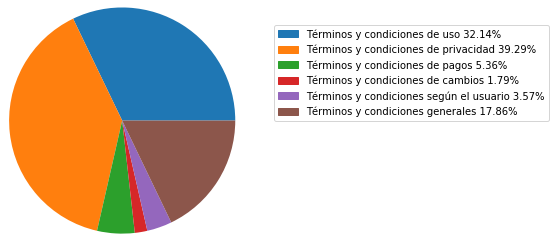

In [27]:
tipos_texto = [condiciones,privacidad,pagos,cambios,2,generales]
porcentajes = [round((i/total)*100,2) for i in tipos_texto]

#Paleta de colores por defecto
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

labels = ['Términos y condiciones de uso','Términos y condiciones de privacidad',
          'Términos y condiciones de pagos','Términos y condiciones de cambios',
          'Términos y condiciones según el usuario','Términos y condiciones generales']

for i in range(len(labels)):
    labels[i]+=" {}%".format(porcentajes[i])

#labels = [labels[i].join(" {}".format(porcentajes[i]))  for i in range(len(labels))]

patches=[]
for i in range(len(tipos_texto)):
    patch = mpatches.Patch(color=colors[i], label=labels[i])
    patches.append(patch)

plt.legend(handles=patches,loc=(1.2,0.5))
plt.pie(tipos_texto,radius=1.3,rotatelabels=1)
plt.show()

## 5.2 Gráficas de los tipos de textos seleccionados para la evaluación

In [28]:
textos = os.listdir(ruta_referencias)
len(textos)

41

In [29]:
#Expresión regular para encontrar la cantidad total de textos de condiciones
condiciones = 0
for texto in textos:
    if re.findall('-condiciones.txt$',texto):
        condiciones+=1
condiciones

11

In [30]:
#Expresión regular para encontrar la cantidad total de textos de privacidad
privacidad = 0
for texto in textos:
    if re.findall('-privacidad.txt$',texto):
        privacidad+=1
privacidad

14

In [31]:
#Expresión regular para encontrar la cantidad total de textos de pagos
pagos = 0
for texto in textos:
    if re.findall('-pagos.txt$',texto):
        pagos+=1
pagos

3

In [32]:
#Expresión regular para encontrar la cantidad total de textos de cambios
cambios = 0
for texto in textos:
    if re.findall('-cambios.txt$',texto):
        cambios+=1
cambios

1

In [33]:
back = privacidad+cambios+pagos+condiciones+2
generales = len(textos) - back
generales

10

In [34]:
total=back+generales

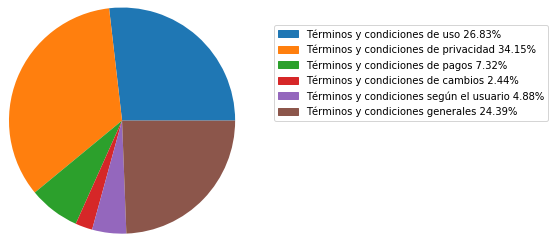

In [35]:
tipos_texto = [condiciones,privacidad,pagos,cambios,2,generales]
porcentajes = [round((i/total)*100,2) for i in tipos_texto]

#Paleta de colores por defecto
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

labels = ['Términos y condiciones de uso','Términos y condiciones de privacidad',
          'Términos y condiciones de pagos','Términos y condiciones de cambios',
          'Términos y condiciones según el usuario','Términos y condiciones generales']

for i in range(len(labels)):
    labels[i]+=" {}%".format(porcentajes[i])

#labels = [labels[i].join(" {}".format(porcentajes[i]))  for i in range(len(labels))]

patches=[]
for i in range(len(tipos_texto)):
    patch = mpatches.Patch(color=colors[i], label=labels[i])
    patches.append(patch)

plt.legend(handles=patches,loc=(1.2,0.5))
plt.pie(tipos_texto,radius=1.3,rotatelabels=1)
plt.show()

## Estimación de la longitud del resumen

In [11]:
textos_recolectados = os.listdir(ruta)
textos_referencias = os.listdir(ruta_referencias)

#Cantidad de frases de todos los textos recolectados
frases_corpus = sentences_path(ruta,textos_recolectados)

#Cantidad de frases de los textos recolectados que fueron resumidos manualmente
frases_referencias =  sentences_path(ruta,textos_referencias)

In [12]:
df = pd.DataFrame(frases_corpus, columns=['cantidad de frases por documento'])
df.describe()

,cantidad de frases por documento
count,56.000000
mean,254.035714
std,166.590403
min,35.000000
25%,125.000000
50%,217.000000
75%,327.250000
max,863.000000


Text(0.5, 0, 'indice de los textos recolectados')

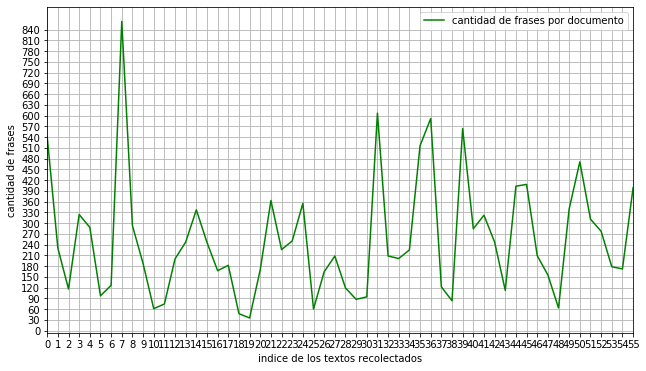

In [13]:
grafica = df.plot(figsize=(10.5,6),color='green',grid=1,xticks=np.arange(0,56,1),yticks=np.arange(0,870,30))
grafica.set_ylabel('cantidad de frases')
grafica.set_xlabel('indice de los textos recolectados')

In [7]:
df.query('`cantidad de frases por documento` < 100')

,cantidad de frases por documento
5,97
10,61
11,74
18,47
19,35
25,60
29,87
30,94
38,83
48,63


In [8]:
df = pd.DataFrame(frases_referencias, columns=['cantidad de frases por documento'])
df.describe()

,cantidad de frases por documento
count,41.000000
mean,263.365854
std,184.805811
min,47.000000
25%,119.000000
50%,209.000000
75%,355.000000
max,863.000000


Text(0.5, 0, 'indice de los textos recolectados que fueron resumidos')

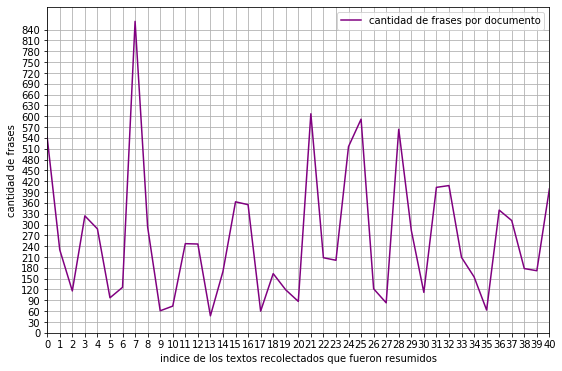

In [9]:
grafica = df.plot(figsize=(9,6),color='purple',grid=1,xticks=np.arange(0,41,1),yticks=np.arange(0,870,30))
grafica.set_ylabel('cantidad de frases')
grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
#a.legend(['cantidad de frases'])

In [17]:
textos_referencias[35]

'twitter-privacidad.txt'